# Histograms with Examples
_Peering inside Histogram Bins with Spark and Bokeh_

<img src="https://github.com/pwais/oarphpy/blob/master/notebooks/hist-with-examples-diag.jpg?raw=true" alt="hist-with-examples" />

A histogram is one of the most effective tools for exploring a new dataset.  In one graph, a histogram displays key information about the data's mean, variance, outliers, and periodic features.  Histograms are so important than several libraries make histogramming extremely easy:
 * In [Pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html), the user can immediately plot a histogram from a Dataframe in a Jupyter notebook with a single function call.
 * [Tensorboard](https://github.com/tensorflow/tensorboard/blob/master/docs/r1/histograms.md) features a powerful temporal histogramming tool that can be critical for monitoring the weights of neural networks during training and debugging high-dimensional optimization problems.
 * [Bokeh](https://demo.bokeh.org/selection_histogram) provides a web-based histogram plotter with interactive tools and a nice Python API.

Histogram plots are often both surprising and boring: some bins have more items than expected, some bins have fewer, and a lot of bins are empty.  It's not unreasonable to immediately want to ask: can we peer inside a bin?  Which examples from my dataset are actually in there?  And, since this histogram only shows one dimension of the data, what might be some other dimensions or factors that are common among most of the things in that bin?

This tutorial will show you how OarphPy's `HistogramWithExamplesPlotter` helps you do exactly that!  What do you need?
 1. A DataFrame (Pandas or Spark) with at least one numeric or categorical column.
 2. A Python function for visualizing a row (or some portion of a row).  For example, a function to convert a row to a pretty string or HTML visualization.
 3. A Jupyter Notebook (like this one!) or a Python script to render the Bokeh HTML plot and display and/or save it to disk.

Why `HistogramWithExamplesPlotter` ?
 * We'll use Spark to compute the actual histogram.  Spark provides multi-cpu (and even multi-machine) processing to make histogramming scale linearly.
 * We'll also use Spark to render visualizations for the bucket items.  Spark's RDD API helps accomodate arbitrary user visualization functions and runs computation in parallel (even across many machines).
 * We use Bokeh's Histogram tool because it supports the simple interactivity we need (click on a bucket to view examples) and plots work in any modern browser with no extra dependencies.



## Notebook Setup

To run this notebook locally, try using the `oarphpy/full` dockerized environment:

```docker run -it --rm --net=host oarphpy/full:0.1.1 jupyter notebook --allow-root --ip="*"```

If you can't run the notebook locally, find an HTML-rendered copy [here](https://drive.google.com/file/d/1-uWxGQ7mrcY8aZMmBDc5AlV4kQAPLntR/view?usp=sharing).

In [1]:
import os
import sys
if 'google.colab' in sys.modules:
    !pip install oarphpy[spark]==0.1.1
    !pip install pyspark==3.3.2
    !apt-get update && apt-get install -y openjdk-11-jdk
    os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

## A Motivating Example: Exploring Out-of-Distribution Robustness in MNIST

<img src="https://miro.medium.com/max/3744/1*SGPGG7oeSvVlV5sOSQ2iZw.png" width="600" />
<center>An MNIST example input fed into a LeNet Network</center>


The [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset is well-studied in Computer Vision and consists of thousands of small pictures of hand-written digits.  (New to MNIST? Suppose you're the Post Office and you want to train a Computer Vision model that can read the zipcode digits that people write on their mail.  MNIST has a sample of such handwritten digits).  Today, it's easy to train a convolutional neural network on MNIST and achieve over 98% accuracy.  We're going to do exactly that in the next notebook cell!  

But MNIST is a relatively small dataset versus all the digits people have ever written on paper.  How robust is a trained MNIST model to new data?  What if we don't have labels for that new data?  In this tutorial, we're going to use `HistogramWithExamplesPlotter` to examine the scores that an MNIST-trained model gives to "corrupted" data never seen at training time.

First, let's train a basic MNIST model using Pytorch:

In [2]:
!pip install -v tqdm torch

Using pip 23.0.1 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


In [3]:
# Basic MNIST ConvNet c/o Pytorch (with some small modifications noted)
# https://github.com/pytorch/examples/blob/40289773aa4916fad0d50967917b3ae8aa534fd6/mnist/main.py#L1

model_ckpt = '/opt/mnist_cnn.pt'

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

torch.manual_seed(1337)
if 'google.colab' in sys.modules:
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

# We need this many epochs to get a nice bimodal score distribution for the 7 class
N_EPOCHS = 15

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        
        # Use softmax instead for easier interpretation of logits
        # output = F.log_softmax(x, dim=1)
        output = F.softmax(x, dim=1)

        return output
    
def train(model, train_loader, optimizer, epoch):
    model.train()
    iter_train = tqdm(enumerate(train_loader), desc='train_batches', total=len(train_loader))
    for batch_idx, (data, target) in iter_train:
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        
        # Push log into the loss instead of net output
        #loss = F.nll_loss(output, target)
        loss = F.nll_loss(torch.log(output), target)
        
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        iter_test = tqdm(test_loader, desc='test_batches', total=len(test_loader))
        for data, target in iter_test:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


train_kwargs = {'batch_size': 128}
test_kwargs = {'batch_size': 1024}
    
transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
])
dataset1 = datasets.MNIST('/opt/mnist-data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('/opt/mnist-data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = Net().to(DEVICE)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

if os.path.exists(model_ckpt):
    print(f"Resuming from existing checkpoint {model_ckpt}")
    print(f"To re-train, delete the checkpoint: $ rm {model_ckpt}")
    model.load_state_dict(torch.load(model_ckpt))
else:
    print(f"Training and saving to {model_ckpt}")

    for epoch in tqdm(range(1, N_EPOCHS + 1), desc='epoch'):
        train(model, train_loader, optimizer, epoch)
        test(model, test_loader)
        scheduler.step()


    torch.save(model.state_dict(), model_ckpt)

x_test = torch.cat([xx[0] for xx in test_loader])

def model_predict(x):
    model.cpu().eval()
    with torch.no_grad():
        prob = model(x)
        pred = prob.argmax(dim=1, keepdim=True)
    return prob, pred



Resuming from existing checkpoint /opt/mnist_cnn.pt
To re-train, delete the checkpoint: $ rm /opt/mnist_cnn.pt


Now, let's run the trained model on the test set and pack the predictions into a Pandas DataFrame.  For each input, the network outputs a score for each class (the numbers 0 through 9).  We'll take a look at the raw network scores for the class "7," which is easy to confused for a "1". 

In [4]:
prob, pred = model_predict(x_test)

rows = []
for i, (x_i, score_i, pred_i) in enumerate(zip(x_test, prob, pred)):
    row = {}
    for classname, score in enumerate(score_i):
        row[f'score_{classname}'] = score.item()
    row['x_i'] = x_i.squeeze().tolist()
    rows.append(row)

import pandas as pd
prediction_df = pd.DataFrame(rows)
prediction_df

,score_0,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,x_i
0,1.666295e-12,9.708602e-11,1.020098e-08,1.268901e-09,4.895701e-12,1.794280e-12,4.720299e-15,1.000000e+00,9.185045e-12,4.956310e-09,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,6.385335e-08,1.281082e-06,9.999985e-01,4.398146e-10,7.451101e-12,7.687796e-13,1.296026e-07,7.235867e-11,1.650108e-09,9.231881e-14,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2.790225e-08,9.999918e-01,2.045216e-07,6.124344e-09,3.181621e-06,9.231777e-08,5.492074e-07,4.090763e-06,1.358098e-07,4.678723e-08,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,9.999950e-01,3.951097e-08,1.086515e-06,3.036769e-09,1.050577e-08,1.097534e-08,3.404809e-06,1.830841e-07,6.096547e-08,9.567390e-08,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,2.000482e-08,2.379246e-08,4.107488e-08,1.893190e-10,9.999777e-01,7.419485e-10,4.249667e-08,1.387315e-08,3.220784e-08,2.214572e-05,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...,...,...
9995,9.127882e-12,8.512246e-08,9.999999e-01,5.384519e-09,2.463138e-14,4.580554e-15,2.152786e-13,1.736553e-08,8.733217e-10,3.547919e-15,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9996,6.531591e-10,2.936270e-09,1.257551e-08,9.999963e-01,1.990298e-11,3.600434e-06,3.078520e-11,4.383115e-09,1.216664e-09,6.073076e-08,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9997,1.076957e-14,7.316457e-10,1.751892e-13,6.589362e-14,1.000000e+00,3.043836e-12,1.105804e-11,2.092271e-09,4.008249e-09,1.101974e-08,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9998,7.055724e-13,8.388026e-13,3.064934e-14,2.192952e-09,2.058131e-14,9.999999e-01,2.026460e-09,2.115985e-13,8.733659e-08,2.399424e-11,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Now let's histogram the network's scores for the 7 class.  Note that since the network has high accuracy, the scores are rather cleanly bi-modal.  For this stage, we'll use the `pandas` built-in `hist()` feature, which gives us a histogram (though without examples or other visualization).

<Axes: >

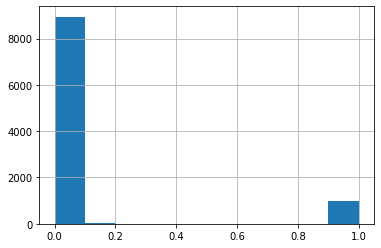

In [5]:
%matplotlib inline 
prediction_df['score_7'].hist()

## Simulating Out-of-Distribution Samples using MNIST-C: Corrupted MNIST

MNIST-C is a benchmark dataset derived from MNIST that has synthetic corruptions.  For example, in MNIST-C, digits are rotated, blurred, speckled, etc.  We will take the normal MNIST model we trained above, run inference on MNIST-C examples, and examine how well the corruption-unaware network generalizes.  This scenario simulates a common situation in production where one has a trained model, lots of unlabeled data, and little tooling for measuring or inspecting error in the wild.  We'll see how `HistogramWithExamplesPlotter` can be a useful tool for quick exploration. 

First, let's get the code for using MNIST-C:

In [6]:
!cd /opt && ((git clone https://github.com/pwais/oarphpy-mirror-mnist-c && \
              cd oarphpy-mirror-mnist-c && git checkout bba57e4ccc282f106907c5239958e72298451ea7) || echo "have mnist-c")
import sys
sys.path.append('/opt/oarphpy-mirror-mnist-c')

# These are hard requirements of the package we need from above
!pip3 install scikit-image==0.19.3
!pip3 install wand scipy
!ln -s /opt/oarphpy-mirror-mnist-c/pessimal_noise_matrix ./pessimal_noise_matrix || echo "symlink placed"
!apt-get install -y libmagickwand-dev


fatal: destination path 'oarphpy-mirror-mnist-c' already exists and is not an empty directory.
have mnist-c
ln: failed to create symbolic link './pessimal_noise_matrix': File exists
symlink placed
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libmagickwand-dev is already the newest version (8:6.9.11.60+dfsg-1.3ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.


Let's take a look at a single corrupted example:

In [7]:
import corruptions

# See more corruptions here: 
# https://github.com/google-research/mnist-c/blob/bba57e4ccc282f106907c5239958e72298451ea7/corruptions.py#L57 

x_to_corrupt = x_test[100].squeeze() * 255
# x_corrupted = corruptions.speckle_noise(x_to_corrupt)
# x_corrupted = corruptions.glass_blur(x_to_corrupt, severity=4)
x_corrupted = corruptions.rotate(x_to_corrupt, severity=4)

x_corrupted.shape

(28, 28)

In [8]:
sys.path.append('/opt/oarphpy')
from oarphpy.plotting import img_to_img_tag

img_html = img_to_img_tag(x_to_corrupt)
img_html_c = img_to_img_tag(x_corrupted)

def show_html(html):
    from IPython.core.display import display, HTML
    display(HTML(html))
show_html('<b>Original:</b>' + img_html)
show_html('<b>Corrupted:</b>' + img_html_c)

Lossy conversion from float32 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 233.87545776367188]. Convert image to uint8 prior to saving to suppress this warning.


Now, let's generated corrupted versions for the entire MNIST test set, and run inference of our earlier model on these corrupted examples:

In [9]:
import numpy as np
x_test_c = np.zeros_like(x_test)
for i in tqdm(range(len(x_test_c)), total=len(x_test_c)):
    # xform = corruptions.glass_blur
    xform = corruptions.rotate
    x_test_c[i][0] = (1. / 255) * xform(x_test[i].squeeze() * 255, severity=4)


  0%|          | 0/10000 [00:00<?, ?it/s]

Let's make sure that worked and also declare a utility function for visualizing digits:

In [10]:
NUM_TO_SHOW = 10

def unit_digit_to_img_tag(x):
    img_char = (255 * x).astype('uint8')
    return img_to_img_tag(img_char)

for r in x_test_c[:NUM_TO_SHOW, ...]:
    x_i = r.squeeze()
    show_html(unit_digit_to_img_tag(x_i))

Now let's run inference on the corrupted data!

In [11]:
prob_c, pred_c = model_predict(torch.from_numpy(x_test_c))

In [12]:
# Aggregate inference results into a dataframe
rows = []
for i, (x_i, score_i, pred_i) in enumerate(zip(x_test_c, prob_c, pred_c)):
    row = {}
    for classname, score in enumerate(score_i):
        row[f'score_{classname}'] = score.item()
    row['x_i'] = x_i.squeeze().tolist()
    rows.append(row)

import pandas as pd
prediction_c_df = pd.DataFrame(rows)
prediction_c_df

,score_0,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,x_i
0,2.318903e-02,3.499873e-02,7.924204e-02,2.462936e-03,7.328708e-01,2.511773e-03,6.940296e-04,5.893948e-02,0.004421,6.067045e-02,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1.368745e-01,1.656399e-01,1.804453e-02,8.661019e-04,2.014344e-02,1.060956e-02,1.852694e-01,3.871693e-02,0.423418,4.180247e-04,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2.822671e-05,9.343426e-01,1.124826e-02,8.512796e-03,1.885175e-03,3.417336e-02,5.489786e-04,2.861198e-03,0.006175,2.248560e-04,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,9.998703e-01,4.705473e-07,1.019485e-05,6.493735e-08,1.318491e-06,8.314926e-06,5.884698e-05,3.484946e-05,0.000013,2.353044e-06,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,2.216400e-03,1.544213e-05,2.452351e-03,3.282306e-04,8.513890e-03,5.292688e-01,2.221072e-02,1.086944e-03,0.264774,1.691330e-01,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...,...,...
9995,1.599001e-04,2.077016e-06,9.966429e-01,1.492914e-04,7.414887e-07,9.567250e-07,5.967238e-06,4.912279e-05,0.002986,3.251638e-06,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9996,2.949015e-03,7.252172e-06,6.446636e-06,3.876572e-05,6.133314e-05,3.019129e-02,1.133591e-05,9.634346e-01,0.000016,3.283608e-03,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9997,3.115887e-07,6.447039e-04,1.315332e-05,2.438993e-06,8.979771e-01,1.953351e-05,3.446408e-07,2.771195e-05,0.000805,1.005097e-01,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9998,4.554707e-02,1.139039e-03,1.794385e-01,7.520212e-04,1.725841e-01,1.347049e-01,1.478239e-01,5.589757e-04,0.009645,3.078060e-01,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Ok, so how did the network score the `7` class in the corrupted data?

<Axes: >

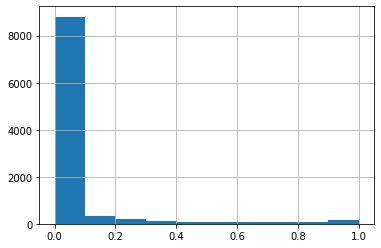

In [13]:
prediction_c_df['score_7'].hist()

Huh, that score distribution is still bi-modal, but is *much more uniform* than the plot we saw earlier.  Clearly the model is making mistakes due to the corruptions.  But what sorts of mistakes?  If we needed to select some of these examples to label, which would we choose?  Let's use `HistogramWithExamplesPlotter` to "peer inside" the histogram buckets of the plot above.

In [20]:
from oarphpy.spark import NBSpark
spark = NBSpark.getOrCreate()


In [21]:
from bokeh.plotting import figure
from bokeh.io import output_notebook
from bokeh.io import show as bokeh_show
output_notebook()


In [22]:
prediction_c_sdf = spark.createDataFrame(prediction_c_df)

# To see the text representation of a Spark Dataframe try:
# prediction_c_sdf.show()

In [ ]:
from oarphpy import plotting as pl
class MyPlotter(pl.HistogramWithExamplesPlotter):
    NUM_BINS = 20
    def display_bucket(self, sub_pivot, bucket_id, irows):
        MAX_TO_VIZ = 50
        
        from oarphpy.plotting import img_to_img_tag
        htmls = []
        for row in irows:
            htmls.append(unit_digit_to_img_tag(np.array(row['x_i'])))
            
            if len(htmls) > MAX_TO_VIZ:
                break
        
        # Make a nice table
        N_COLS = 25
        from oarphpy.util import ichunked
        trs = [
            "<tr>%s</tr>" % ''.join("<td>%s</td>" % ihtml for ihtml in row)
            for row in ichunked(htmls, n=N_COLS) 
        ]
        table_html = "<table>%s</table>" % ''.join(trs)
        
        return bucket_id, table_html

plotter = MyPlotter()
fig = plotter.run(prediction_c_sdf, 'score_7')
bokeh_show(fig)

In [18]:
fig = plotter.run(spark.createDataFrame(prediction_c_df), 'score_1')
bokeh_show(fig)

The two figures above examine the model's inferences on the _corrupted_ dataset.  Let's use `HistogramWithExamplesPlotter` to visualize the inference results on the original MNIST dataset to compare:

In [19]:
fig = plotter.run(spark.createDataFrame(prediction_df), 'score_7')
bokeh_show(fig)

For more examples of `HistogramWithExamplesPlotter`, see these rendered HTML pages: https://drive.google.com/drive/folders/1dOmkPvdFiGBMaYEddx1KK5vmCeYl2CyV?usp=sharing 